# Symmetries and VMC
In this tutorial, we will learn how to use symmetries of quantum Hamiltonian to enhance the performance of a VMC calculation. More specifically, you will learn:


* How to symmetrize a `vstate` with respect to lattice symmetries. 
* How to implement custom symmetries.


## Transverse field Ising model
We will consider the transverse field Ising model on a 2d $L \times L$ square lattice: 

$$
\hat H = h \sum_i \hat \sigma_i^x + J \sum_{\langle i j \rangle} \hat \sigma_i^z \hat \sigma_j^z
$$

where $\hat \sigma_i^\alpha$ is the Pauli operator for spin component $\alpha \in \{x,y,z,\}$ and $\langle ij\rangle$ denotes pairs of nearest neighbors on the lattice. 

We will assume periodic boundary conditions




## Setting up the problem

### Definining the lattice
First, we need to define a square lattice. This is done using the ```netket.graph.Square``` class. For this tutorial, we will pick $L=4$.


In [1]:
#import netket
import netket as nk

In [2]:
#defined the square lattice
square_lattice = nk.graph.Square(length=4, pbc=True) # 4x4 square lattice with periodic boundary conditions

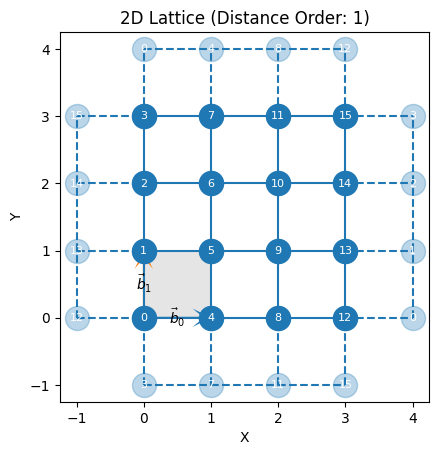

<Axes: title={'center': '2D Lattice (Distance Order: 1)'}, xlabel='X', ylabel='Y'>

In [3]:
square_lattice.draw()

### Defining the Hilbert space
Then, we need to define the Hilbert space on which this model is defined. The relevant class here is `netket.hilbert.Spin`

In [4]:
hilbert = nk.hilbert.Spin(s=0.5, N=square_lattice.n_nodes) #16 spin 1/2 particles 
import numpy as np

In [5]:
print('Number of local degrees of freedom: {}'.format(hilbert.size))
print('Number of states: {}'.format(hilbert.n_states))

Number of local degrees of freedom: 16
Number of states: 65536


### Constructing the Hamiltonian
Now we will construct the Hamiltonian of this system.

In [6]:
#import the fermionic creation and annihilation operators
from netket.operator.spin import sigmax, sigmaz

In [7]:
H = 0
h = -1.0
J = -1.0

for i,j in square_lattice.edges():
    H += J * sigmaz(hilbert=hilbert, site=i) * sigmaz(hilbert=hilbert, site=j)

for i in range(square_lattice.n_nodes):
    H += h * sigmax(hilbert=hilbert, site=i)

## Exact diagonalization (ED)

Since $\hat H$ is sparse and its dimension is not too big, we can perform ED to get the ground state energy.

In [8]:
from scipy.sparse.linalg import eigsh

In [9]:
H_sp = H.to_sparse()
evals, evecs = eigsh(H_sp, k=1, which='SA')  # 'SA' means smallest algebraic eigenvalue
print("Ground state energy (exact diagonalization): ", evals[0])

Ground state energy (exact diagonalization):  -34.0105975508463


## Symmetries
The Hamiltonian commutes with the set of operators that correspond to a *representation* of the space group of the lattice. From representation theory, we know that we can use the irreducible representations (irreps) of the group to block diagonalize $\hat H$ and restrict the search for the ground state to a particular irrep. 


The first step in doing this is to select the relevant group. 

Here, we will consider the translation group of the lattice. 

In [10]:
translation_group = square_lattice.translation_group()
for g in translation_group: 
    print(g)

Id()
Translation([0, 1])
Translation([0, 2])
Translation([0, 3])
Translation([1, 0])
Translation([1, 1])
Translation([1, 2])
Translation([1, 3])
Translation([2, 0])
Translation([2, 1])
Translation([2, 2])
Translation([2, 3])
Translation([3, 0])
Translation([3, 1])
Translation([3, 2])
Translation([3, 3])


The elements of `translation_group` correspond to permutations of the lattice sites. 

In [11]:
print("Permutation corresponding to a translation by R= [0,1]: ", translation_group[1].permutation_array)

Permutation corresponding to a translation by R= [0,1]:  [ 1  2  3  0  5  6  7  4  9 10 11  8 13 14 15 12]


We can also view the characters which classify different irreducible representations.

In [12]:
print("Second row of the character table:", translation_group.character_table()[1])

Second row of the character table: [ 1.+0.j  1.+0.j  1.+0.j  1.+0.j  0.+1.j  0.+1.j  0.+1.j  0.+1.j -1.+0.j
 -1.+0.j -1.+0.j -1.+0.j  0.-1.j  0.-1.j  0.-1.j  0.-1.j]


As it turns out, the characters of the translation group can all be written in the form:

$$\chi_{\vec k}(\vec R) = e^{i \vec k \cdot \vec R}$$

where $\chi_{\vec k}(\vec R)$ is the character corresponding to the translation by a lattice vector $\vec R$ and $\vec k$ is a vector in the first Brillouin zone.  

In principle, the true ground state may be found at any value of $\vec k$. However, due to symmetry, we can restrict our search for the ground state to the *irreducible Brillouin zone* (red triangle on the plot below). 

Text(0.5, 1.0, 'Brillouin zone of the square lattice')

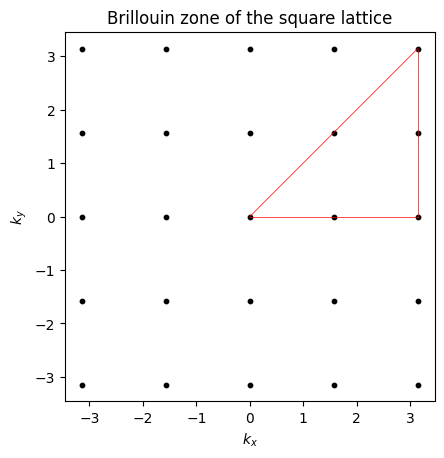

In [13]:
import matplotlib.pyplot as plt
kx = np.linspace(-np.pi, np.pi, 4+1, endpoint=True)
ky = np.linspace(-np.pi, np.pi, 4+1, endpoint=True)

Kx, Ky = np.meshgrid(kx, ky)
plt.scatter(Kx.flatten(), Ky.flatten(), s=10, color='black')
plt.plot([0,np.pi], [0, np.pi], color='r', lw=0.5)
plt.plot([0,np.pi], [0, 0], color='r', lw=0.5)
plt.plot([np.pi, np.pi], [0, np.pi], color='r', lw=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.title('Brillouin zone of the square lattice')

We need to find which rows of the character table correspond to these special $\vec k$ points. 

In [14]:
BZ = np.column_stack((Kx.flatten(), Ky.flatten()))
irred_BZ = BZ[(BZ[:, 0] >= 0) & (BZ[:, 1] >= 0) & (BZ[:, 1] <= BZ[:, 0])]

irrep_ids = []
for k in irred_BZ: 
    # Find the index of the row in the character table that matches the momentum irrep for k
    irrep = np.round(translation_group.momentum_irrep(k),8) #round to avoid numerical precision issues
    idx = np.where(np.all(np.round(translation_group.character_table(),8) == irrep, axis=1))[0] #also round the character table
    irrep_ids.append(idx[0])

    print("Index of matching character table row for k ={}: {}".format(k, idx))


Index of matching character table row for k =[0. 0.]: [0]
Index of matching character table row for k =[1.57079633 0.        ]: [2]
Index of matching character table row for k =[3.14159265 0.        ]: [3]
Index of matching character table row for k =[1.57079633 1.57079633]: [9]
Index of matching character table row for k =[3.14159265 1.57079633]: [11]
Index of matching character table row for k =[3.14159265 3.14159265]: [15]


Now we know which $\vec k$ points interest us. The next step is to construct ```netket.operator``` objects from the group elements 
that can act on the states of the Hilbert space. This is known as a *representation*. For lattice symmetries, `netket` has built in methods
to construct representations, which is done using the `Representation`class. 

In [15]:
translation_group_representation = square_lattice.translation_group_representation(hilbert=hilbert)

In `netket`, a `Representation` object can be constructed by specifying a dictionary whose values are the elements of the representation. In this example, the elements of the translation group may be represented by `PermutationOperator` objects. These encode how permutations of the lattice sites act on the local degrees of freedom of the Hilbert space. 

**REFER TO DOC HERE**


They are equipped with a `get_conn_padded` method, allowing them to act on states of the basis. 

In the next section, we will discuss in more detail how to construct `Representation` for custom groups. 

## VMC

Within the VMC scheme, wavefunction amplitudes may be made symmetric with respect to a particular group $G$ and irrep $\mu$ using the following projection formula:

$$\psi_\mu(x) = \frac{1}{|G|} \sum_{g \in G} \chi_\mu^\ast(g) \psi( g^{-1}x)$$
where $x$ is the encoding of a basis state, $|G|$ is the number of elements in the group, $\chi_\mu(g)$ is the character of the representation evaluated on element $g$ and $\hat U_g$ is the representation of $g$ on the Hilbert space. Here $\psi(g^{-1}x)$ is the *left action* of element $g$ on the state $x$. 

In the context of permutations and spin systems, we can view $g$ as a function from $\{0,\ldots, n-1\} \to \{0, \ldots, n-1\}$ and $x$ as a function from $\{0,\ldots, n-1\} \to \{0,1\}$ such that the left action is the composition:


$$\psi(g^{-1}x) = \psi(x \circ g)$$ 

**REFER TO DOC FOR MORE DETAILS**

In the following, we will compare the performance of an unsymmetrized ansatz versus a symmetrized one.

In [16]:
model = nk.models.RBM(alpha=2) #define a restricted Boltzmann machine with hidden unit density alpha=2
sampler = nk.sampler.MetropolisLocal(hilbert=hilbert) #Metropolis-Hastings local sampler
optimizer = nk.optimizer.Sgd(learning_rate=5e-3) #stochastic gradient descent optimizer
solver  = nk.optimizer.solver.cholesky
preconditioner = nk.optimizer.SR(solver=solver, diag_shift=1e-6) #stochastic reconfiguration preconditioner

In [17]:
#train the unsymmetrized model
unsymmetrized_log = nk.logging.RuntimeLog()
unsymmetrized_vstate = nk.vqs.MCState(sampler, model, n_samples = 256, n_discard_per_chain= 10)
unsymmetrized_log = nk.logging.RuntimeLog()
driver = nk.VMC(H, optimizer, variational_state=unsymmetrized_vstate)
driver.preconditioner = preconditioner
driver.run(n_iter=500, out=unsymmetrized_log)


  0%|          | 0/500 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

To construct a symmetry projected wavefunction in netket, we use `project` method of the `Representation` class. 
This method takes in a variational state as well as the integer correspond to the id of the irrep. 
It then implements the above equation

In [18]:
vstate=nk.vqs.MCState(sampler, model, n_samples = 256, n_discard_per_chain= 10)
symmetrize_vstate0 = translation_group_representation.project(state=vstate, character_index=0) #project on the trivial represention

Then we just run the optimization as usual!

In [19]:
driver = nk.VMC(H, optimizer, variational_state=symmetrize_vstate0)
driver.preconditioner = preconditioner
driver.run(n_iter=500, out=nk.logging.RuntimeLog())

  0%|          | 0/500 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

The true ground state is not necessarily in the trivial representation. In the case of the translation group, we need to run the optimization over all points in the irreducible Brillouin zone. 
To achieve this, we will loop through the relevant irrep ids. For each irrep, we will do a full optimization run and then append the optimized vstate to a list. 

In [21]:
symm_vstate_list = [symmetrize_vstate0,] #list to hold the symmetrized vstates
for i in irrep_ids[1:]: #we have already done the trivial irrep
    print("optimizing in irrep id: {}".format(i))
    i = i
    vstate=nk.vqs.MCState(sampler, model, n_samples = 256, n_discard_per_chain= 10)
    symmetrize_vstate = translation_group_representation.project(state=vstate, character_index=i) #project on the trivial represention
    driver = nk.VMC(H, optimizer, variational_state=symmetrize_vstate)
    driver.preconditioner = preconditioner
    driver.run(n_iter=500, out=nk.logging.RuntimeLog())
    symm_vstate_list.append(symmetrize_vstate)

optimizing in irrep id: 2


  0%|          | 0/500 [00:00<?, ?it/s]

optimizing in irrep id: 3


  0%|          | 0/500 [00:00<?, ?it/s]

optimizing in irrep id: 9


  0%|          | 0/500 [00:00<?, ?it/s]

optimizing in irrep id: 11


  0%|          | 0/500 [00:00<?, ?it/s]

optimizing in irrep id: 15


  0%|          | 0/500 [00:00<?, ?it/s]

For each optimized vstate, we can estimate the converged energy and plot the energy vs irrep id. 

In [22]:
energy_stats = []

for vstate in symm_vstate_list:
    
    stats = vstate.expect(H)
    data = (float(stats.mean.real), float(stats.error_of_mean.real))
    energy_stats.append(data)

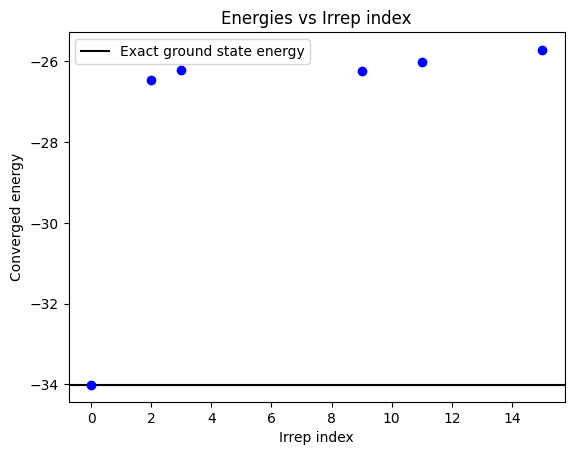

In [23]:
for index, data in zip(irrep_ids, energy_stats):
    plt.errorbar(index, data[0], yerr=data[1], fmt='o', color = 'blue')
plt.xlabel('Irrep index')
plt.ylabel('Converged energy')
plt.axhline(evals[0], c= 'k', label ='Exact ground state energy')
plt.title('Energies vs Irrep index')
plt.legend()

In this case, the trivial representation is the most energetically favorable one. 
We can now compare the energy performance of the symmetrized state with $\vec k = \vec 0$ versus the non-symmetrized one. 

In [24]:
def relative_error(approx, exact):
    return np.abs((approx - exact) / exact)

E_no_symm = float(unsymmetrized_vstate.expect(H).mean.real)
E_symm = energy_stats[0][0]

print("Relative error without symmetrization: {:.3e}".format(relative_error(E_no_symm, evals[0])))
print("Relative error with symmetrization in the trivial irrep: {:.3e}".format(relative_error(E_symm, evals[0])))   

Relative error without symmetrization: 2.044e-04
Relative error with symmetrization in the trivial irrep: 3.608e-05


In this case, the symmetrized model performed slightly better than the non-symmetrized one. 
Let's now check how the symmetrization impacts the spin-spin correlation function: 

$$S_{0,i} = \langle \hat \sigma_0^z \hat \sigma_i^z \rangle$$

In [25]:
vals_unsymm = []
vals_symm = []
for i in range(square_lattice.n_nodes):

    op = sigmaz(hilbert=hilbert, site=0) * sigmaz(hilbert=hilbert, site=i)
    vals_unsymm.append(float(unsymmetrized_vstate.expect(op).mean.real))
    vals_symm.append(float(symm_vstate_list[0].expect(op).mean.real))

    

In [26]:
vals_unsymm_2d = np.array(vals_unsymm).reshape((4,4))
vals_symm_2d = np.array(vals_symm).reshape((4,4))

In [30]:
vals_symm_2d

array([[1.       , 0.9140625, 0.96875  , 0.96875  ],
       [0.953125 , 0.9765625, 0.9609375, 0.9609375],
       [0.9609375, 0.9765625, 0.9453125, 0.9453125],
       [0.9453125, 0.9140625, 0.96875  , 0.9609375]])

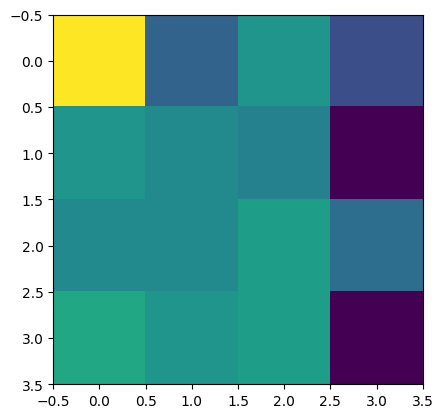

In [27]:
plt.imshow(vals_unsymm_2d)

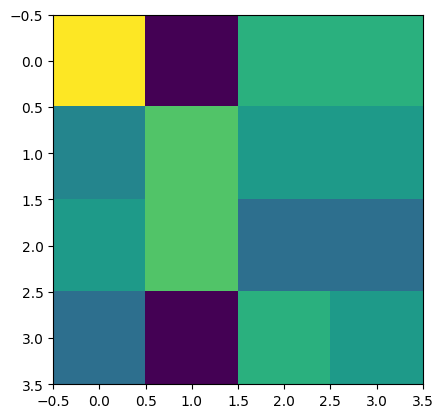

In [28]:
plt.imshow(vals_symm_2d)

In [29]:
vals_symm_2d

array([[1.       , 0.9140625, 0.96875  , 0.96875  ],
       [0.953125 , 0.9765625, 0.9609375, 0.9609375],
       [0.9609375, 0.9765625, 0.9453125, 0.9453125],
       [0.9453125, 0.9140625, 0.96875  , 0.9609375]])